In [4]:
import json
import pandas as pd
import sys

sys.path.append("../../")

from config import DATA_DIR
from graph_types.graph import Graph

graph_name = "amazon"

In [2]:
# graph = Graph.load(graph_name)

In [12]:
logs_dir = DATA_DIR / f"experiments/{graph_name}/subgraph_explorer"
json_files = sorted([f for f in logs_dir.glob("*.json")], key=lambda x: x.stat().st_ctime)

data = []

for json_file in json_files:
    with open(json_file, "r") as f:
        log_data = json.load(f)

    # Extract key information from each log entry
    record = {
        "file_id": int(json_file.stem),
        "question": log_data.get("question", ""),
        "all_nodes": log_data.get("all_nodes", []),
        "message_histories": log_data.get("message_histories", ""),
        "starting_nodes_indices": log_data.get("starting_nodes_indices", []),
        "agent_answer_indices": log_data.get("agent_answer_indices", []),
        "answer_indices": log_data.get("answer_indices", []),
    }

    data.append(record)

df = pd.DataFrame(data).reset_index(drop=True)# .sort_values(by="file_id").reset_index(drop=True)

df["recall@all"] = df.apply(
    lambda row: len(set(row["answer_indices"]).intersection(set(row["agent_answer_indices"])))
    / len(set(row["answer_indices"])),
    axis=1,
)
df["hit@1"] = df.apply(
    lambda row: (
        row["agent_answer_indices"][0] in row["answer_indices"]
        if row["agent_answer_indices"]
        else False
    ),
    axis=1,
)
df["hit@5"] = df.apply(
    lambda row: len(set(row["answer_indices"]).intersection(set(row["agent_answer_indices"][:5])))
    > 0,
    axis=1,
)
df["hit@10"] = df.apply(
    lambda row: len(set(row["answer_indices"]).intersection(set(row["agent_answer_indices"][:10])))
    > 0,
    axis=1,
)
df["recall@10"] = df.apply(
    lambda row: len(set(row["answer_indices"]).intersection(set(row["agent_answer_indices"][:10])))
    / len(set(row["answer_indices"])),
    axis=1,
)
df["recall@20"] = df.apply(
    lambda row: len(set(row["answer_indices"]).intersection(set(row["agent_answer_indices"][:20])))
    / len(set(row["answer_indices"])),
    axis=1,
)

[
    ("n", len(df)),
    ("Hit@1", float(round(df["hit@1"].mean(), 3))),
    ("Hit@5", float(round(df["hit@5"].mean(), 3))),
    ("Recall@10", float(round(df["recall@10"].mean(), 3))),
    ("Recall@20", float(round(df["recall@20"].mean(), 3))),
    ("Recall@all", float(round(df["recall@all"].mean(), 3))),
]

[('n', 42),
 ('Hit@1', 0.405),
 ('Hit@5', 0.595),
 ('Recall@10', 0.296),
 ('Recall@20', 0.301),
 ('Recall@all', 0.301)]

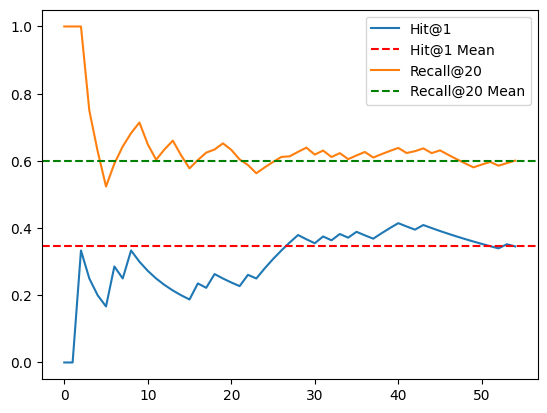

In [214]:
import matplotlib.pyplot as plt
plt.plot([df['hit@1'].iloc[:i].mean() for i in range(1, len(df) + 1)], label='Hit@1')
plt.axhline(y=df['hit@1'].mean(), color='r', linestyle='--', label='Hit@1 Mean')
plt.plot([df['recall@20'].iloc[:i].mean() for i in range(1, len(df) + 1)], label='Recall@20')
plt.axhline(y=df['recall@20'].mean(), color='g', linestyle='--', label='Recall@20 Mean')
plt.legend()


### Are the answers we don't match mentioned in the reasoning?

In [215]:
graph = Graph.load(graph_name)

In [216]:
df['answer_names'] = df['answer_indices'].apply(lambda x: [graph.get_node_by_index(i).name for i in x])

In [217]:
df[df["recall@all"] == 0].apply(
    lambda row: all([name in str(row["message_histories"]) for name in row["answer_names"]]), axis=1
).value_counts()

False    12
True      5
Name: count, dtype: int64

In [218]:
len(df[df['agent_answer_indices'].apply(lambda x: len(x) == 0)])

2

In [219]:
(df["recall@all"].sum() + 10) / len(df)

np.float64(0.8007070707070707)

In [220]:
df['question'][0]

'Could you provide a list of treatments suitable for someone with mucopolysaccharidosis and Scheie syndrome?'

In [221]:
df[['answer_indices', 'agent_answer_indices', 'answer_names']].iloc[0]

answer_indices                                      [20647]
agent_answer_indices    [17948, 20565, 20649, 17947, 20647]
answer_names                                   [Laronidase]
Name: 0, dtype: object

In [222]:
df['starting_nodes_indices'].apply(lambda x: [graph.get_node_by_index(i).name for i in x]).iloc[0]

['mucopolysaccharidosis', 'Scheie syndrome']

In [223]:
df['agent_answer_indices'].apply(lambda x: [(graph.get_node_by_index(i).name + str(graph.get_node_by_index(i).details)) for i in x]).iloc[0]

AttributeError: 'PrimeNode' object has no attribute 'details'

In [ ]:
df['message_histories'][0]

[[{'role': 'user',
   'content': 'Question: Could you provide a list of treatments suitable for someone with mucopolysaccharidosis and Scheie syndrome?\nYou are standing on node: mucopolysaccharidosis\n\nYour objective is to find the nodes that are the answer to the question. \nFor this, you can\n- search in the surroundings of this node with `search_in_surroundings` tool. You can also use this to see the neighbors of this node, setting k=1.\n- find the path that connects this node to another node with the `find_paths` tool\n- `submit_answer` when you think you found the nodes.\n\nConsider searching for keywords and then finding paths to understand the connections between nodes.\n'},
  {'role': 'assistant',
   'tool_calls': [{'id': 'call_MRNKixa9mnDn2JLuhKVawtP4',
     'type': 'function',
     'function': {'name': 'search_in_surroundings',
      'arguments': '{"query": "treatment", "type": "drug", "k": 2}'}},
    {'id': 'call_e9mEN99QSFVD9O6Wmomqy9dK',
     'type': 'function',
     'fu